(section:results_theodorsen)=
# Identification of the Theodorsen model by treating $C_L$ as a state

The goal of the following 2-step numerical experiment was to replicate the behaviour of the Theodorsen model by using SINDy on trajectory datasets comprising of the inputs $u = [\ddot \alpha, \ddot h]$ and a state vector expanded to include the lift coefficient $C_L$. The goal was to overcome the fact that SINDy estimates the full-state output model of the system (i.e. the $A$ and $B$ matrices in the case of an LTI system), without regarding how the states contribute to the final output (i.e. not estimating the $C$ and $D$ matrices in case of an LTI system). This limitation is not fundamental, since having estimated the states, the $x \rightarrow y$ relationship can be estimated by a second regression step, but simplyfying the process into one regression step was an interesting alternative.

## Derivation of the extended Theodorsen model with $C_L$ as a state

Given an LTI approximation to the Theodorsen model of the form:

$$\dot{x} = Ax + Bu = A \begin{bmatrix} \tilde{x}\\ \dot{h}\\ \alpha\\ \dot{\alpha} \end{bmatrix} + B \begin{bmatrix}\ddot{h}\\ \ddot{\alpha}\end{bmatrix}$$

the derivative of the lift coefficient can be expressed as:

$$\dot{C}_L = \frac{d}{dt}(Cx + Du) = C\dot{x} + D\dot{u} = CAx + CBu + D\dot{u}$$

The equation above has one undesireable property — the differentiation of $u$. This problem can be mitigated by defining a lift coefficient with the influence of the $D$ matrix subtracted:

$$C_L^x = C_L - Du$$

$$\dot{C}_L^x = CAx + CBu$$

The above equation is a valid state-space model. The separation of the $Du$ term is not a big issue, given that it can be easily estimated independently {cite}`brunton_reduced-order_2013`.

The final state-space representation of the model is:

$$\dot{\hat{x}} = \frac{d}{dt} \begin{bmatrix}x\\ C_L^x\end{bmatrix} = \begin{bmatrix}A & 0\\ CA & 0\end{bmatrix} \hat{x} + \begin{bmatrix}B \\ CB \end{bmatrix} u$$

## Identification of the extended Theodorsen model with $C_L$ as a state
The following code shows that this model can be identified (with some caveats) using SINDy. Training is performed on 5 selected datasets, while validation on yet another one.

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import control
import Theodorsen_control as theodorsen # our library for using Theodorsen model LTI approximations
import pysindy
import signals # our library with identification signals
import sklearn as sk
import scipy.fftpack

plt.rcParams["figure.figsize"]=(8,6)
seed = np.array([0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,1,1,1,0,1,1,0,1,1,0,1,0,0])
#seed for consistence; generated by np.random.randint(low=0, high=2, size=31)

np.random.seed(seed=1345098234) # second seed for constistence

The parameters of the airfoil:

In [2]:
a = 0.5  # pitch axis wrt to 1/2-chord
b = 1.  # half-chord length of the airfoil
# default values of C_1 and C_2 used
airfoil = theodorsen.AirfoilGeometry(a=a, b=b)

The 4-state approximation of the Theodorsen fuction from {cite}`brunton2013empirical` is used in the full Thedorsen state-space LTI approximation:

In [3]:
# the balanced truncation Theodorsen function approximation
theodorsen_function_sys = theodorsen.theodorsen_function_balanced_truncation_ss()

# state-space system with both α" and h" as inputs
theodorsen_full_sys = theodorsen.unsteady_lift_ss(
    airfoil, theodorsen_function_sys)

A class for processing trajectory datasets is implemented:

In [4]:
class TrajectoryDatasets:
    '''Collection of unsteady lift time series (with states, inputs etc).'''

    def __init__(self, theodorsen_sys, observe_states_from=0):
        self.x = []
        self.t = []
        self.u = []
        self.C_L = []
        self.data = []
        self.theodorsen_sys = theodorsen_sys
        self.observe_states_from = observe_states_from

    def add_dataset(self, t, u_alpha, u_h, plot=True, states_from=0):
        '''Create a dataset with given time and inputs.'''
        u_MISO = np.vstack((u_h.T, u_alpha.T))

        # time response
        output = control.forced_response(
            self.theodorsen_sys, T=t, U=u_MISO)

        # time response postprocessing
        data = theodorsen.TheodorsenTimeResponse(
            output, inputs='both', sys=self.theodorsen_sys)

        if plot:
            data.io_plot()

        # new results-
        self.t.append(t)
        self.u.append(u_MISO)
        self.C_L.append(data.C_L)
        self.x.append(data.x[self.observe_states_from:, :])
        self.data.append(data)

    def C_L_without_Du(self, num=None):
        '''Compute C_L(t)-Du(t).'''
        if num is not None:
            Du = self.theodorsen_sys.D @ self.u[num]
            C_L_Du = self.C_L[num].T - Du
        else:
            C_L_Du = []
            for i, C_L in enumerate(self.C_L):
                Du = self.theodorsen_sys.D @ self.u[i]
                C_L_Du.append(C_L - Du)
        return C_L_Du

    def x_with_C_L_Du(self):
        '''Extend the state vector by adding C_L-Du to the bottom.'''
        x_extended = []
        for i, x in enumerate(self.x):
            x_extended.append(np.vstack((x, self.C_L_without_Du(i))))
        return x_extended

The class is instantiated:

In [5]:
datasets = TrajectoryDatasets(theodorsen_full_sys)

### Training data

5 carefully chosen trajectories with various combinations of input signals are generated as the training dataset:

In [6]:
t_end = 20 # length of cases (except for one)
t = np.linspace(0, t_end, 1000) # time array

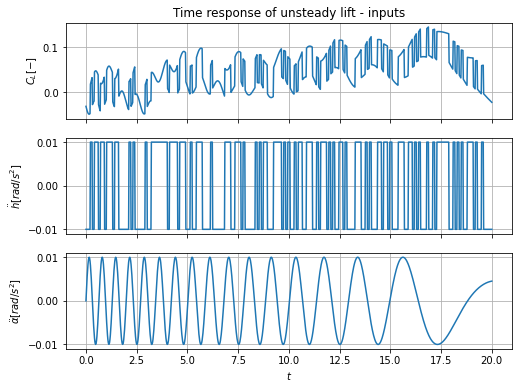

In [7]:
# CASE 1
u_alpha = signals.linear_chirp(t, omega_init=10, omega_end=0.1, amplitude=0.01)
u_h = signals.prbs(t, dt=0.1, min=-0.01, max=0.01, seed=seed)
datasets.add_dataset(t, u_alpha, u_h, plot=True)


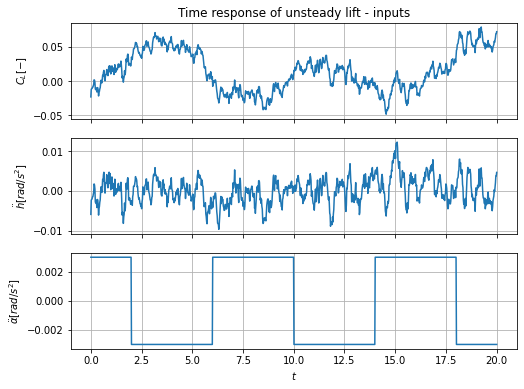

In [8]:
# CASE 2
u_alpha = signals.square_wave(t, T=4, phase=2, amplitude=0.003)
u_h = signals.white_noise_averaged(t, sigma=0.01, mean=0, averaging_radius=5)
datasets.add_dataset(t, u_alpha, u_h, plot=True)

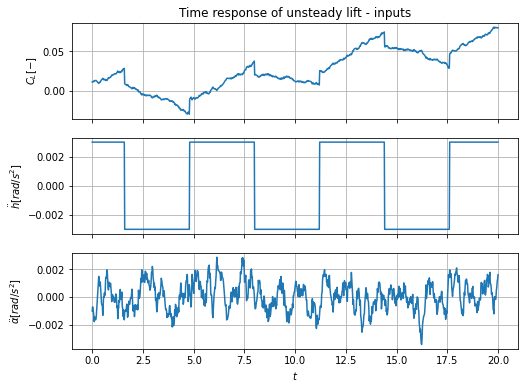

In [9]:
# CASE 3
u_alpha = signals.white_noise_averaged(
    t, sigma=0.003, mean=0, averaging_radius=5)
u_h = signals.square_wave(t, T=3.2, phase=1.6, amplitude=0.003)
datasets.add_dataset(t, u_alpha, u_h, plot=True)

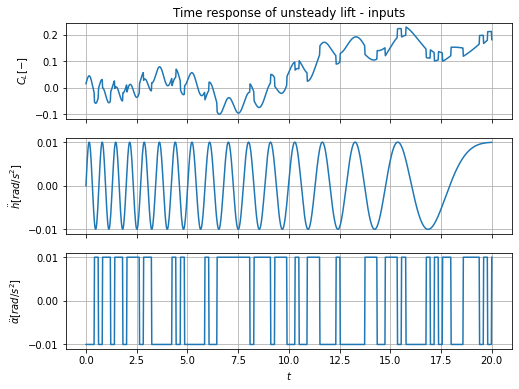

In [10]:
# CASE 4
u_alpha = signals.prbs(t, dt=0.2, min=-0.01, max=0.01, seed=seed)
u_h = signals.linear_chirp(t, omega_init=10, omega_end=0.2, amplitude=0.01)
datasets.add_dataset(t, u_alpha, u_h, plot=True)

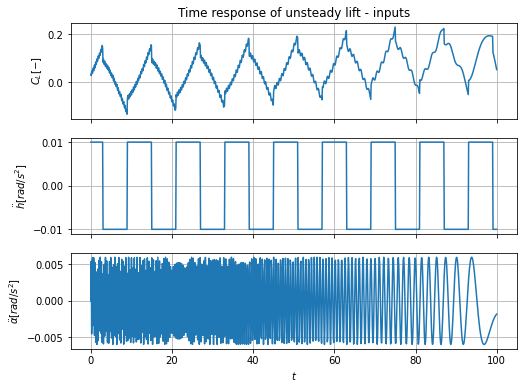

In [11]:
# CASE 5
# this case uses a longer time period to capture more low-frequency dynamics of the chirp
t_long = np.linspace(0, 100, 1000)
u_alpha = signals.linear_chirp(
    t_long, omega_init=20, omega_end=0.1, amplitude=0.006)
u_h = signals.square_wave(t_long, T=6, phase=3, amplitude=0.01)
datasets.add_dataset(t_long, u_alpha, u_h, plot=True)

### Training

The SINDy identification is set up and trained on the dataset shown above.

In [12]:
%%capture

def transpose_all(list_of_arrays):
    '''Transpose all arrays in a list'''
    return [a.T for a in list_of_arrays]

optimizer = pysindy.optimizers.stlsq.STLSQ(
    threshold=1e-2, alpha=0.0)

model = pysindy.SINDy(optimizer=optimizer,
                      feature_library=pysindy.PolynomialLibrary(degree=1))

# training
model.fit(transpose_all(datasets.x_with_C_L_Du()),
          t=datasets.t, u=transpose_all(datasets.u), multiple_trajectories=True)

In [13]:
print('Identified model:')
model.print()

Identified model:
(x0)' = -0.871 x0 + -0.116 x1 + 13.064 x4 + 13.058 x5 + 6.882 x6 + -2.180 x7
(x1)' = 1.000 x0
(x2)' = 1.000 x1
(x3)' = 1.000 x2
(x4)' = 0.953 u0
(x5)' = 1.000 x6
(x6)' = 0.945 u1
(x7)' = -0.063 x0 + 2.305 x4 + 2.250 x5 + 4.301 x6 + -0.396 x7 + 2.945 u0 + 2.961 u1


### Validation
The model is validated on another dataset:

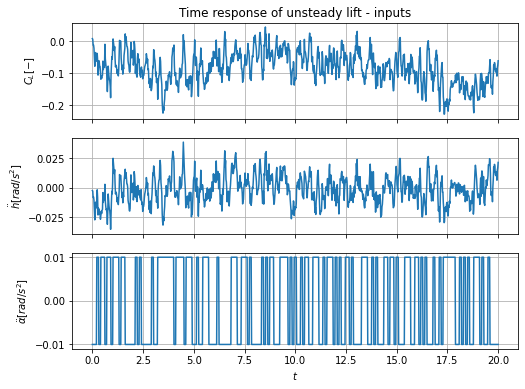

In [14]:
# validation scenario
u_alpha = signals.prbs(t, dt=0.1, min=-0.01, max=0.01, seed=seed) # signals.square_wave(t, T=3, phase=1.5, amplitude=0.01)
u_h = signals.white_noise_averaged(t, sigma=0.03, averaging_radius=3)
u_MISO_validation = np.vstack((u_h.T, u_alpha.T))

# time response
output = control.forced_response(
    theodorsen_full_sys, T=t, U=u_MISO_validation)

# time response postprocessing
data = theodorsen.TheodorsenTimeResponse(
    output, inputs='both', sys=theodorsen_full_sys)

data.io_plot()

In [15]:
%%capture
# simulating the output of the identified model
x_model = model.simulate(x0=np.zeros((8, )), t=t, u=u_MISO_validation.T)

The results are plotted for a visual comparison:

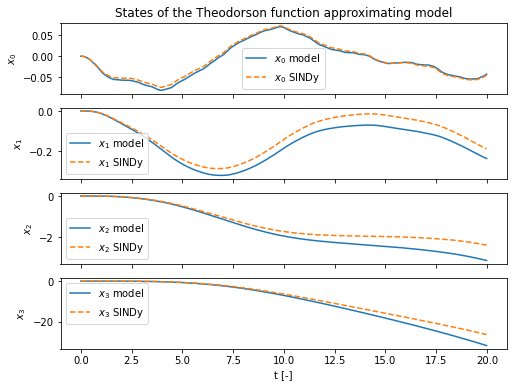

In [16]:
# plot of the Theodorsen function states
for i in range(4):
    plt.subplot(4, 1, i+1)
    if i == 0:
        plt.title('States of the Theodorson function approximating model')
    plt.plot(data.t[:-1], data.x_theodorsen[i, :-1],
             '-', label='$x_{}$ model'.format(i))
    plt.plot(data.t[:-1], x_model[:, i], '--', label='$x_{}$ SINDy'.format(i))
    if i < 3:
        plt.tick_params('x', labelbottom=False)
    plt.ylabel('$x_{}$'.format(i))
    plt.legend()
plt.xlabel('t [-]')
plt.show()

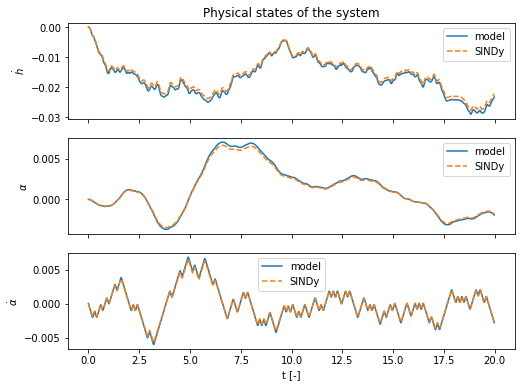

In [17]:
# plot of the "physical" states
# h'
plt.subplot(3, 1, 1)
plt.title('Physical states of the system')
plt.tick_params('x', labelbottom=False)
plt.plot(data.t[:-1], data.h_dot[:-1], '-', label='model')
plt.plot(data.t[:-1], x_model[:, 4], '--', label='SINDy')
plt.ylabel(r'$\dot{h}$')
plt.legend()
plt.tick_params('x', labelbottom=False)
# alpha
plt.subplot(3, 1, 2)
plt.tick_params('x', labelbottom=False)
plt.plot(data.t[:-1], data.alpha[:-1], '-', label='model')
plt.plot(data.t[:-1], x_model[:, 5], '--', label='SINDy')
plt.ylabel(r'$\alpha$')
plt.legend()
plt.tick_params('x', labelbottom=False)
# alpha'
plt.subplot(3, 1, 3)
plt.plot(data.t[:-1], data.alpha_dot[:-1], '-', label='model')
plt.plot(data.t[:-1], x_model[:, 6], '--', label='SINDy')
plt.xlabel('t [-]')
plt.ylabel(r'$\dot{\alpha}$')
plt.legend()
plt.show()

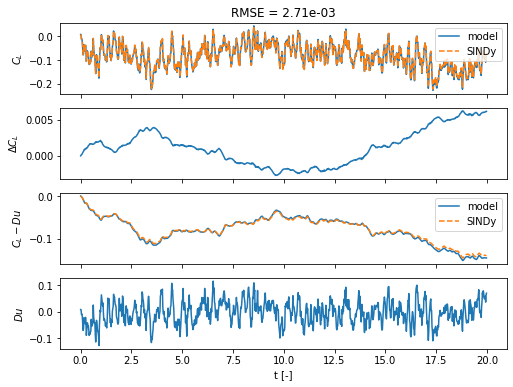

In [18]:
# plot of C_L
# C_L_SINDy computed using the true C and D, because this usecase of SINDy does not estimate them
Du = theodorsen_full_sys.D @ data.u
C_L_SINDy = (np.atleast_2d(x_model[:, 7]).T + Du.T[:-1])
rmse = sk.metrics.mean_squared_error(data.C_L[:-1], C_L_SINDy, squared=False)
plt.subplot(4, 1, 1)
plt.plot(data.t[:-1], data.C_L[:-1], '-', label='model')
plt.plot(data.t[:-1], C_L_SINDy, '--', label='SINDy')
plt.title('RMSE = {:.2e}'.format(rmse))
plt.ylabel('$C_L$')
plt.legend()
plt.tick_params('x', labelbottom=False)

plt.subplot(4, 1, 2)
plt.plot(data.t[:-1], C_L_SINDy - data.C_L[:-1], '-')
plt.ylabel('$\Delta C_L$')
plt.tick_params('x', labelbottom=False)

plt.subplot(4, 1, 3)
C_L_x_SINDy = np.atleast_2d(x_model[:, 7]).T
Du = (theodorsen_full_sys.D @ data.u).T
plt.plot(data.t[:-1], data.C_L[:-1] - Du[:-1], '-', label='model')
plt.plot(data.t[:-1], C_L_x_SINDy, '--', label='SINDy')
plt.ylabel('$C_L - Du$')
plt.legend()
plt.tick_params('x', labelbottom=False)

plt.subplot(4, 1, 4)
plt.plot(data.t[:-1], Du[:-1], '-')
plt.ylabel('$Du$')
plt.xlabel('t [-]')
plt.show()

It can be seen that all the states of the system are replicated correctly, and the validation $C_L$ has a very small root mean square error (RMSE). This demonstrates that adding $C_L^x$ as a state is a viable modification of the identification problem.

## Identification of an approximated Theodorsen model without the $\tilde{x}$ states

While the above demonstration proved that $C_L$ can be successfully treated as a state for identification, it was not practical in nature, because as of now we do not have access to the Theodorsen function states $\tilde{x}$ from CFD data, nor can we assume that the low Reynolds number problems will use the same reduced flow state $\tilde{x}$. Because of this, a second experiment has been performed. The only difference with respect to the previous one is that the only states available to SINDy are:

$$x' = [\dot{h}, \alpha, \dot{\alpha}, C_L]^T$$

The rationale is that the aforementioned states are always available, so it might be of interest to create a model that instead of the reduced flow states $\tilde{x}$ utilises nonlinear relationships between the $x'$ states.

The description of the identification process is less verbose, because it is identical to the previous one, aside from ignoring the $\tilde{x}$ states.

### Setup

In [19]:
datasets = TrajectoryDatasets(theodorsen_full_sys, observe_states_from=4)

### Training data

In [20]:
# CASE 1
u_alpha = signals.linear_chirp(t, omega_init=10, omega_end=0.1, amplitude=0.01)
u_h = signals.prbs(t, dt=0.1, min=-0.01, max=0.01, seed=seed)
datasets.add_dataset(t, u_alpha, u_h, plot=False)

# CASE 2
u_alpha = signals.square_wave(t, T=4, phase=2, amplitude=0.003)
u_h = signals.white_noise_averaged(t, sigma=0.01, mean=0, averaging_radius=5)
datasets.add_dataset(t, u_alpha, u_h, plot=False)

# CASE 3
u_alpha = signals.white_noise_averaged(
    t, sigma=0.003, mean=0, averaging_radius=5)
u_h = signals.square_wave(t, T=3.2, phase=1.6, amplitude=0.003)
datasets.add_dataset(t, u_alpha, u_h, plot=False)

# CASE 4
u_alpha = signals.prbs(t, dt=0.2, min=-0.01, max=0.01, seed=seed)
u_h = signals.linear_chirp(t, omega_init=10, omega_end=0.2, amplitude=0.01)
datasets.add_dataset(t, u_alpha, u_h, plot=False)

# CASE 5
u_alpha = signals.linear_chirp(
    t_long, omega_init=20, omega_end=0.1, amplitude=0.006)
u_h = signals.square_wave(t_long, T=6, phase=3, amplitude=0.01)
datasets.add_dataset(t_long, u_alpha, u_h, plot=False)

### Training
For additional insights, two models are trained: one using a polynomial base of order 1, while the second one — of order 2.

In [21]:
# SYSTEM IDENTIFCATION

optimizer = pysindy.optimizers.stlsq.STLSQ(
    threshold=1e-2, alpha=0.0)
model_1 = pysindy.SINDy(optimizer=optimizer,
                      feature_library=pysindy.PolynomialLibrary(degree=1))
optimizer = pysindy.optimizers.stlsq.STLSQ(
    threshold=1e-2, alpha=0.0)
model_2 = pysindy.SINDy(optimizer=optimizer,
                      feature_library=pysindy.PolynomialLibrary(degree=2))

# training
model_1.fit(transpose_all(datasets.x_with_C_L_Du()),
          t=datasets.t, u=transpose_all(datasets.u), multiple_trajectories=True)
print('Identified model (order 1):')
model_1.print()

model_2.fit(transpose_all(datasets.x_with_C_L_Du()),
          t=datasets.t, u=transpose_all(datasets.u), multiple_trajectories=True)
print('Identified model (order 2):')
model_2.print()

Identified model (order 1):
(x0)' = 0.047 x0 + 0.058 x1 + 0.022 x2 + -0.012 x3 + 0.947 u0
(x1)' = 1.000 x2
(x2)' = 0.945 u1
(x3)' = 1.525 x0 + 1.555 x1 + 4.064 x2 + -0.277 x3 + 3.026 u0 + 2.957 u1
Identified model (order 2):
(x0)' = 0.076 x0 + 0.096 x1 + 0.042 x2 + -0.019 x3 + 0.942 u0 + -4.727 x0^2 + -15.917 x0 x1 + -6.649 x0 x2 + 2.872 x0 x3 + 2.250 x0 u0 + -2.094 x0 u1 + -12.747 x1^2 + -9.058 x1 x2 + 4.673 x1 x3 + 3.245 x1 u0 + -2.604 x1 u1 + -2.106 x2^2 + 1.580 x2 x3 + 2.039 x2 u0 + -1.493 x2 u1 + -0.423 x3^2 + -0.651 x3 u0 + 0.546 x3 u1 + 0.536 u0^2 + 0.548 u0 u1 + 0.924 u1^2
(x1)' = 1.000 x2 + 0.217 x0 x2 + 0.211 x1 x2 + 0.088 x2^2 + -0.049 x2 x3 + 0.011 x2 u1
(x2)' = -0.052 x0 + -0.071 x1 + -0.015 x2 + 0.013 x3 + 0.931 u1 + -1.207 x0^2 + 0.101 x0 x1 + 2.937 x0 x2 + 0.312 x0 x3 + -1.105 x0 u0 + 2.562 x0 u1 + 2.340 x1^2 + 3.057 x1 x2 + -0.458 x1 x3 + -1.575 x1 u0 + 5.444 x1 u1 + 1.064 x2^2 + -0.549 x2 x3 + -1.286 x2 u0 + 2.357 x2 u1 + 0.362 x3 u0 + -0.968 x3 u1 + 0.682 u0^2 + 0.24

### Validation
The model is validated on another dataset:

In [22]:
# time response
output = control.forced_response(
    theodorsen_full_sys, T=t, U=u_MISO_validation)

# time response postprocessing
data = theodorsen.TheodorsenTimeResponse(
    output, inputs='both', sys=theodorsen_full_sys)

In [23]:
%%capture
# simulating the output of the identified model
x_model_1 = model_1.simulate(x0=np.zeros((4, )), t=t, u=u_MISO_validation.T)

The trajectory of the second degree nonlinear system is not generated here due to computational cost, but its results turned out to be completely equivalent. Note that even its 1st order terms are very similar. Due do this, the second degree model was not considered in the following parts.

The results are plotted for a visual comparison:

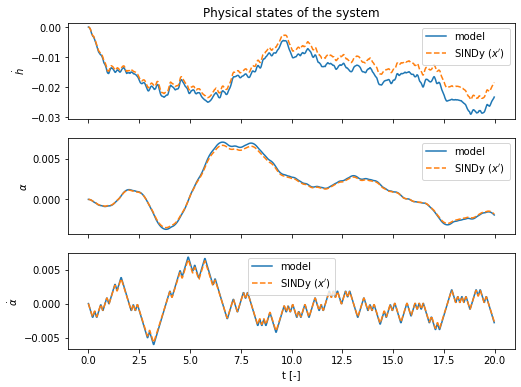

In [24]:
# plot of the "physical" states
# h'
plt.subplot(3, 1, 1)
plt.title('Physical states of the system')
plt.tick_params('x', labelbottom=False)
plt.plot(data.t[:-1], data.h_dot[:-1], '-', label='model')
plt.plot(data.t[:-1], x_model_1[:, 0], '--', label='SINDy ($x\'$)')
plt.ylabel(r'$\dot{h}$')
plt.legend()
plt.tick_params('x', labelbottom=False)
# alpha
plt.subplot(3, 1, 2)
plt.tick_params('x', labelbottom=False)
plt.plot(data.t[:-1], data.alpha[:-1], '-', label='model')
plt.plot(data.t[:-1], x_model_1[:, 1], '--', label='SINDy ($x\'$)')
plt.ylabel(r'$\alpha$')
plt.legend()
plt.tick_params('x', labelbottom=False)
# alpha'
plt.subplot(3, 1, 3)
plt.plot(data.t[:-1], data.alpha_dot[:-1], '-', label='model')
plt.plot(data.t[:-1], x_model_1[:, 2], '--', label='SINDy ($x\'$)')
plt.xlabel('t [-]')
plt.ylabel(r'$\dot{\alpha}$')
plt.legend()
plt.show()

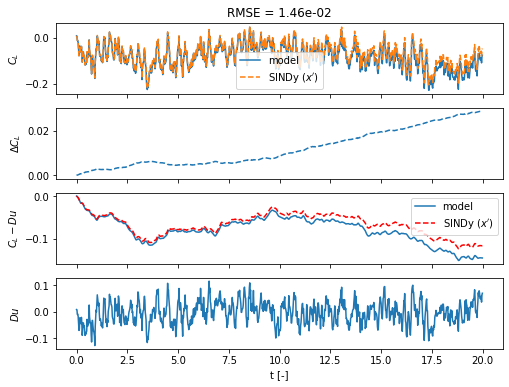

In [25]:
# plot of C_L
# C_L_SINDy computed using the true C and D, because this usecase of SINDy does not estimate them
Du = theodorsen_full_sys.D @ data.u
C_L_SINDy_1 = (np.atleast_2d(x_model_1[:, 3]).T + Du.T[:-1])
C_L_SINDy_2 = (np.atleast_2d(x_model_1[:, 3]).T + Du.T[:-1])
rmse_1 = sk.metrics.mean_squared_error(data.C_L[:-1], C_L_SINDy_1, squared=False)
rmse_2 = sk.metrics.mean_squared_error(data.C_L[:-1], C_L_SINDy_2, squared=False)
plt.subplot(4, 1, 1)
plt.plot(data.t[:-1], data.C_L[:-1], '-', label='model')
plt.plot(data.t[:-1], C_L_SINDy_1, '--', label='SINDy ($x\'$)')
plt.title('RMSE = {:.2e}'.format(rmse_1))
plt.ylabel('$C_L$')
plt.legend()
plt.tick_params('x', labelbottom=False)

plt.subplot(4, 1, 2)
plt.plot(data.t[:-1], C_L_SINDy_1 - data.C_L[:-1], '--')
plt.ylabel('$\Delta C_L$')
plt.tick_params('x', labelbottom=False)

plt.subplot(4, 1, 3)
C_L_x_SINDy_1 = np.atleast_2d(x_model_1[:, 3]).T
C_L_x_SINDy_2 = np.atleast_2d(x_model_1[:, 3]).T
Du = (theodorsen_full_sys.D @ data.u).T
plt.plot(data.t[:-1], data.C_L[:-1] - Du[:-1], '-', label='model')
plt.plot(data.t[:-1], C_L_x_SINDy_1, 'r--', label='SINDy ($x\'$)')
plt.ylabel('$C_L - Du$')
plt.legend()
plt.tick_params('x', labelbottom=False)

plt.subplot(4, 1, 4)
plt.plot(data.t[:-1], Du[:-1], '-')
plt.ylabel('$Du$')
plt.xlabel('t [-]')
plt.show()

It can be seen that all the states of the system are replicated correctly, and the validation $C_L$ still has a small root mean square error (RMSE), although about an order of magnitude larger than the previous case, where $\tilde{x}$ was part of the training data. It is also important to note that the 1st and 2nd order models have almost equivalent performance, with the 1st order performing even slightly better in predicting $\alpha$. This suggest that the attenuating influence of the Thedorsen function states $\tilde{x}$ can't be expressed as quadratic nonlinearities of the $x'$ states (or at least that such relationships are not straightforward to identify), and that the linear dynamics of $x'$ are the dominating effect in the data. The second statement might raise doubts whether the wake effects are captured by the identified model at all. This is verified by comparing the data with a simplified Theodorsen model that simplifies the attenuating effects of the wake into a constang gain and no phase shift, i.e. assuming that the Theodorsen function $C(k)$ is constant for all $k$. The 3 values of interest: $C(k)=1$ (the low-frequency limit of the function), $C(k) = 0.25$ (the high-frequency limit) and $C(k) = 0.7$ (the intermediate value, corresponding to frequencies of the order of $0.5 [rad/s]$):

$$C_L^{(C(k)=1} = C_1 (\ddot{h} + \dot{\alpha} + a\ddot{\alpha}) + C_2(\alpha + \dot{h} + \dot{\alpha}(1/2-a))C(k)$$

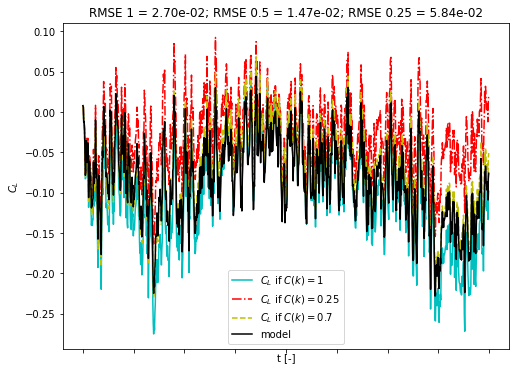

In [26]:
C_L_AMQS_1 = (airfoil.C_1*(data.h_ddot + data.alpha_dot - airfoil.a*data.alpha_ddot) +
           airfoil.C_2*(data.alpha + data.h_dot + data.alpha_dot*(0.5-airfoil.a))).T
C_L_AMQS_07 = (airfoil.C_1*(data.h_ddot + data.alpha_dot - airfoil.a*data.alpha_ddot) +
           0.7*airfoil.C_2*(data.alpha + data.h_dot + data.alpha_dot*(0.5-airfoil.a))).T
C_L_AMQS_025 = (airfoil.C_1*(data.h_ddot + data.alpha_dot - airfoil.a*data.alpha_ddot) +
           0.25*airfoil.C_2*(data.alpha + data.h_dot + data.alpha_dot*(0.5-airfoil.a))).T

C_L_AMQS_1 = np.reshape(C_L_AMQS_1, (len(t),1))
C_L_AMQS_07 = np.reshape(C_L_AMQS_07, (len(t),1))
C_L_AMQS_025 = np.reshape(C_L_AMQS_025, (len(t),1))

rmse_1 = sk.metrics.mean_squared_error(data.C_L, C_L_AMQS_1, squared=False)
rmse_2 = sk.metrics.mean_squared_error(data.C_L, C_L_AMQS_07, squared=False)
rmse_3 = sk.metrics.mean_squared_error(data.C_L, C_L_AMQS_025, squared=False)

plt.plot(data.t[:-1], C_L_AMQS_1[:-1], 'c-', label='$C_L$ if $C(k)=1$')
plt.plot(data.t[:-1], C_L_AMQS_025[:-1], 'r-.', label='$C_L$ if $C(k)=0.25$')
plt.plot(data.t[:-1], C_L_AMQS_07[:-1], 'y--', label='$C_L$ if $C(k)=0.7$')
plt.plot(data.t[:-1], data.C_L[:-1], 'k-', label='model')
plt.title('RMSE 1 = {:.2e}; RMSE 0.5 = {:.2e}; RMSE 0.25 = {:.2e}'.format(rmse_1, rmse_2, rmse_3))
plt.ylabel('$C_L$')
plt.xlabel('t [-]')
plt.legend()
plt.tick_params('x', labelbottom=False)

A comparison is made between the error of the simplified models with various values of $C(k)$, the model identified using $x'$ and the model identified previously using 'x':

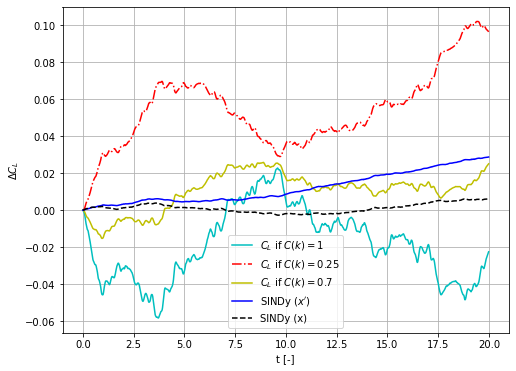

In [27]:
plt.plot(data.t[:-1], C_L_AMQS_1[:-1]-data.C_L[:-1], 'c-', label='$C_L$ if $C(k)=1$')
plt.plot(data.t[:-1], C_L_AMQS_025[:-1]-data.C_L[:-1], 'r-.', label='$C_L$ if $C(k)=0.25$')
plt.plot(data.t[:-1], C_L_AMQS_07[:-1]-data.C_L[:-1], 'y-', label='$C_L$ if $C(k)=0.7$')
plt.plot(data.t[:-1], C_L_SINDy_1-data.C_L[:-1], 'b-', label='SINDy ($x\'$)')
plt.plot(data.t[:-1], C_L_SINDy-data.C_L[:-1], 'k--', label='SINDy (x)')
plt.grid(True)
plt.ylabel('$\Delta C_L$')
plt.xlabel('t [-]')
plt.legend()
plt.show()

It can be seen that none of the limit values of $C(k)$ provides an error as small as the identified model. The intermediate value $C(k)=0.8$ achieves a similar RMSE. However, the identified model's error evolves in a much more predictable way, most likely due to the integrative properties of the model accumulating error over time, while the simplified model's error is more erratic. This suggests that the identified model actually does capture some of the effects of the Theodorsen function, and, by extension, of the quasi-steady lift attenuation by the wake behind the airfoil. This is possible, because the identified model has the form:

$$\frac{d}{dt} C_L^x = a_1 \dot{h} + a_2 \alpha + a_3 \dot{\alpha} + a_4 C_L + b_1 \ddot{h} + b_2 \ddot{\alpha} $$

where $a_i$ are the significant identified coefficients of the last row of the $A'$ matrix, while the $b_i$ — of the $B'$ matrix. The simplified model, on the other hand, after subtracting the $Du$ term and differentiating would have form:

$$\frac{d}{dt} C_L^x = b_1 \ddot{h} + b_2 \ddot{\alpha} + a_3 \dot{\alpha}$$

where the $a_i$ and $b_i$ terms are the constant terms depending on $a$, $C_1$, $C_2$ and the (constant) $C(k)$ value, named the same way as their corresponding terms in the identified model. It is immediately visible that the identified model has strictly more terms than the simplified one, meaning that it should able to model more complex dynamics. That being said, the model identified using $x$ shows a noticeably smaller error, highliting the usefullness of additional states related to the unsteady flow.

## Conclusions

It has been shown that adding $C_L^x = C_L - Du$ to the state vector of the training data is a viable strategy for identification of the unsteady lift dynamical system. It was also discovered that using only $x' = [\dot{h}, \alpha, \dot{\alpha}, C_L^x]$ as states can still yield a model of acceptable performance, and that it seems that the attenuation effects of the Theodorsen function on the lift can be at least partially modeled by a linear system with only $x'$ as states. The latter fact, combined with more in-depth analysis, can help with the choice of states for the low Reynolds number unsteady lift models seeked in the future.